# Statistical Exploratory Data Analysis
### Earthquake magnitude distribution in California from 1966 to 2022 (57 years) (extract from the ANSS catalog).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns


In [4]:
df = pd.read_csv("/Users/amina/Desktop/Erthquake/data/earthquake data.csv", parse_dates=["DateTime"])

In [5]:
#Calculating b-value with MLE

max_magnitude = df['Magnitude'].max()
print("Maximum Magnitude (⟨M⟩):", max_magnitude)
# Calculate the average magnitude (⟨M⟩)
average_magnitude = np.mean(df['Magnitude'])

# Minimum magnitude (Mmin)
min_magnitude = min(df['Magnitude'])

# Calculate the b-value
b_value = np.log10(np.e) / (average_magnitude - min_magnitude)

# Print the result
print("Average Magnitude (⟨M⟩):", average_magnitude)
print("Minimum Magnitude (Mmin):", min_magnitude)
print("b-Value calculated using maximum likelihood:", b_value)
print("(⟨M⟩ - Mmin)",average_magnitude - min_magnitude)


Maximum Magnitude (⟨M⟩): 7.2
Average Magnitude (⟨M⟩): 2.9551765588406047
Minimum Magnitude (Mmin): 2.5
b-Value calculated using maximum likelihood: 0.9541231275385922
(⟨M⟩ - Mmin) 0.4551765588406047


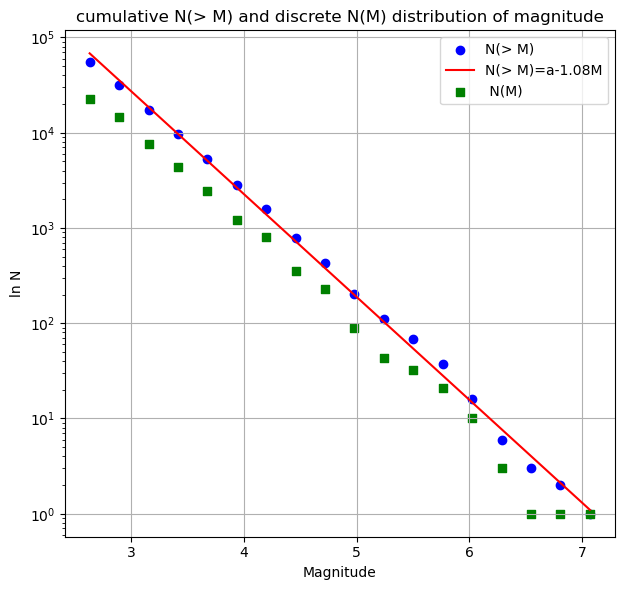

Slope (b-value): 1.079550586984792
Parameter a (intercept): 7.6732978141975146


In [6]:


def calculate_histogram(df, num_bins=18, min_mag=min_magnitude, max_mag=max_magnitude):
    # Calculate the histogram
    hist, edges = np.histogram(df['Magnitude'], bins=num_bins, range=(min_mag, max_mag))
    return hist, edges

def calculate_cumulative_histogram(hist):
    # Calculate the cumulative histogram
    cumulative_hist = np.cumsum(hist[::-1])[::-1] #calculated right-to-left then flipped back so bin order is preserved
    log_cumulative_hist = np.log10(cumulative_hist)
    return log_cumulative_hist

def calculate_magnitude_bins(edges):
    # Calculate the midpoints of the bins
    magnitude_bins = (edges[:-1] + edges[1:]) / 2
    return magnitude_bins

def calculate_linear_regression(magnitude_bins, log_cumulative_hist):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(magnitude_bins, log_cumulative_hist)
    return slope, intercept

def plot_histogram_and_regression(magnitude_bins, log_cumulative_hist, log_hist):
    # Plot both in a single figure
    plt.figure(figsize=(12, 6))

    # Log Cumulative N(> M) plot plt.loglog
    plt.subplot(1, 2, 1)
    plt.scatter(magnitude_bins, 10**log_cumulative_hist, marker='o', label="N(> M)", color='blue')
    plt.plot(magnitude_bins, 10**(slope * magnitude_bins + intercept), color='red', label=f'N(> M)=a-{abs(slope):.2f}M')
    plt.scatter(magnitude_bins, 10**log_hist, marker='s', label=" N(M)", color='green')
    plt.xlabel('Magnitude')
    plt.ylabel('ln N')
    plt.title('cumulative N(> M) and discrete N(M) distribution of magnitude')
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def print_regression_parameters(slope, intercept):
    # Print results
    print("Slope (b-value):", -slope)
    print("Parameter a (intercept):", intercept)

# Main code
hist, edges = calculate_histogram(df)
log_cumulative_hist = calculate_cumulative_histogram(hist)
magnitude_bins = calculate_magnitude_bins(edges)
slope, intercept = calculate_linear_regression(magnitude_bins, log_cumulative_hist)
log_hist = np.log10(hist)  # Logarithm of histogram
plot_histogram_and_regression(magnitude_bins, log_cumulative_hist, log_hist)
print_regression_parameters(slope, intercept)


Histogram bin counts: This is an array containing the number of data points that fall within each bin of the histogram.

Bin edges: These are the values that define the boundaries of each bin in the histogram. The first element in the edges array represents the lower limit of the first bin, the second element represents the upper limit of the first bin, and so on. Essentially, the bin edges create the bins that the data points are counted within.

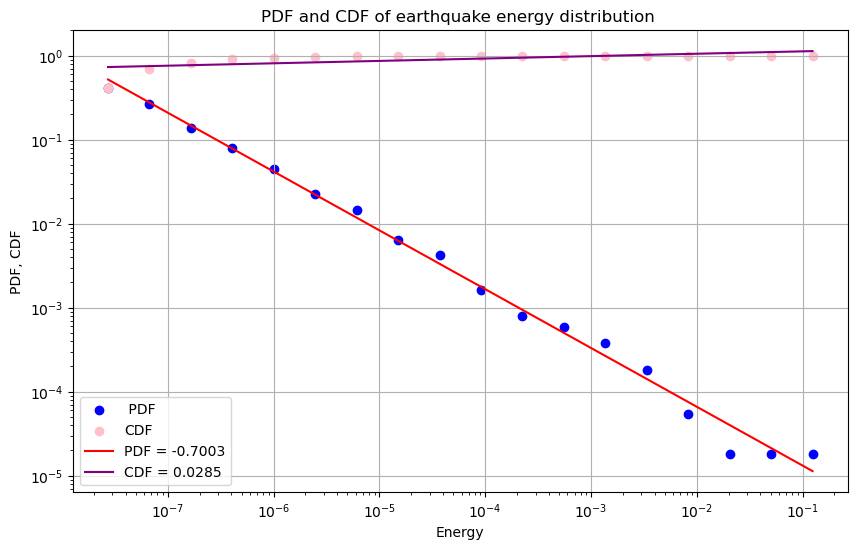

PDF Slope: -0.7003124820290786
CDF Slope: 0.0284659051503654


In [7]:

def calculate_energy(magnitude_bins, intercept):
    """Calculate energy from magnitude bins."""
    energy = 10**((3/2) * (magnitude_bins - intercept))
    return energy

def calculate_pdf(hist, edges):
    """Calculate PDF from histogram."""
    pdf = hist / np.diff(edges)
    return pdf

def normalize_pdf(pdf):
    """Normalize PDF."""
    normalized_pdf = pdf / np.sum(pdf)
    return normalized_pdf

def calculate_cdf(normalized_pdf):
    """Calculate CDF from normalized PDF."""
    cdf = np.cumsum(normalized_pdf)
    return cdf

def plot_energy_pdf_and_cdf(energy, normalized_pdf, cdf, pdf_regression_line, cdf_regression_line):
    """Plot Energy vs. Normalized PDF and CDF along with regression lines."""
    plt.figure(figsize=(10, 6))
    plt.scatter(energy, normalized_pdf, marker='o', color='blue', label=' PDF')
    plt.scatter(energy, cdf, marker='o', color='pink', label='CDF')

    # Linear regression for PDF
    plt.plot(energy, pdf_regression_line, color='red', label=f'PDF = {pdf_slope:.4f}')

    # Linear regression for CDF
    plt.plot(energy, cdf_regression_line, color='purple', label=f'CDF = {cdf_slope:.4f}')

    plt.xlabel('Energy')
    plt.ylabel('PDF, CDF')
    plt.title('PDF and CDF of earthquake energy distribution ')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()

    plt.show()

def print_regression_parameters(pdf_slope, cdf_slope):
    """Print regression slopes."""
    print("PDF Slope:", pdf_slope)
    print("CDF Slope:", cdf_slope)

# Main code
energy = calculate_energy(magnitude_bins, intercept)
pdf = calculate_pdf(hist, edges)
normalized_pdf = normalize_pdf(pdf)
cdf = calculate_cdf(normalized_pdf)

# Linear regression for PDF
pdf_slope, pdf_intercept, _, _, _ = linregress(np.log(energy), np.log(normalized_pdf))
pdf_regression_line = np.exp(pdf_intercept) * (energy ** pdf_slope)

# Linear regression for CDF
cdf_slope, cdf_intercept, _, _, _ = linregress(np.log(energy), np.log(cdf))
cdf_regression_line = np.exp(cdf_intercept) * (energy ** cdf_slope)

plot_energy_pdf_and_cdf(energy, normalized_pdf, cdf, pdf_regression_line, cdf_regression_line)
print_regression_parameters(pdf_slope, cdf_slope)


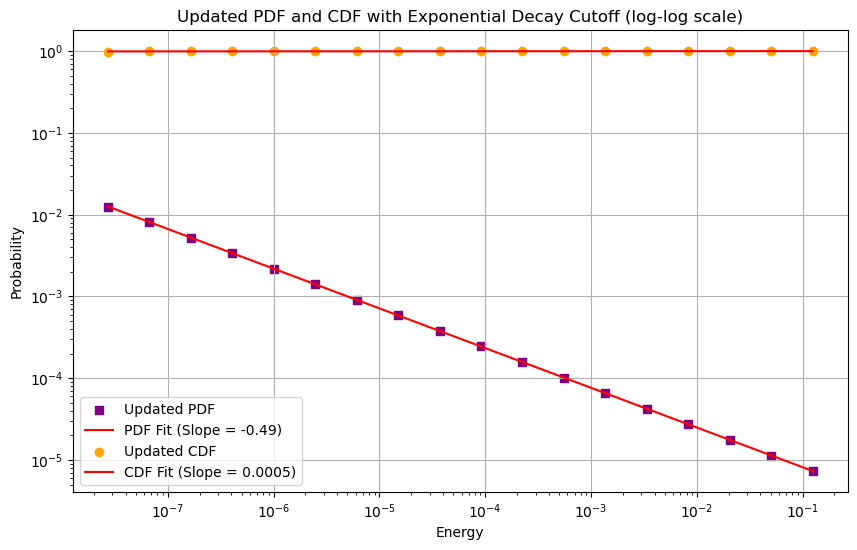

In [8]:


def calculate_updated_pdf(magnitude_bins, beta, s_0):
    """Calculate updated PDF based on the formulas."""
    pdf_updated = magnitude_bins**(-beta-1) * np.exp(-magnitude_bins/s_0)
    return pdf_updated

def fit_line_to_pdf(energy, pdf_updated):
    """Fit a line to the updated PDF."""
    pdf_slope, pdf_intercept, _, _, _ = linregress(np.log(energy), np.log(pdf_updated))
    pdf_fit_line = np.exp(pdf_intercept) * (energy ** pdf_slope)
    return pdf_slope, pdf_fit_line

def calculate_updated_cdf(magnitude_bins, s_0):
    """Calculate updated CDF based on the formulas."""
    cdf_updated = 1 - np.exp(-magnitude_bins/s_0)
    return cdf_updated

def fit_line_to_cdf(energy, cdf_updated):
    """Fit a line to the updated CDF."""
    cdf_slope, cdf_intercept, _, _, _ = linregress(np.log(energy), np.log(cdf_updated))
    cdf_fit_line = np.exp(cdf_intercept) * (energy ** cdf_slope)
    return cdf_slope, cdf_fit_line

def plot_updated_pdf_cdf(energy, pdf_updated, pdf_fit_line, cdf_updated, cdf_fit_line, pdf_slope, cdf_slope):
    """Create a log-log plot for the updated PDF and CDF."""
    plt.figure(figsize=(10, 6))
    # Updated PDF
    plt.scatter(energy, pdf_updated, marker='s', label='Updated PDF', color='purple')
    plt.plot(energy, pdf_fit_line, color='red', label=f'PDF Fit (Slope = {pdf_slope:.2f})')
    # Updated CDF
    plt.scatter(energy, cdf_updated, marker='o', label='Updated CDF', color='orange')
    plt.plot(energy, cdf_fit_line, color='red', label=f'CDF Fit (Slope = {cdf_slope:.4f})')
    plt.xlabel('Energy')
    plt.ylabel('Probability')
    plt.title('Updated PDF and CDF with Exponential Decay Cutoff (log-log scale)')
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.legend()
    plt.grid()
    plt.show()

# Main code
# Parameters
beta = slope
s_0 = 0.59 # Cutoff size
pdf_updated = calculate_updated_pdf(magnitude_bins, beta, s_0)
pdf_slope, pdf_fit_line = fit_line_to_pdf(energy, pdf_updated)
cdf_updated = calculate_updated_cdf(magnitude_bins, s_0)
cdf_slope, cdf_fit_line = fit_line_to_cdf(energy, cdf_updated)
plot_updated_pdf_cdf(energy, pdf_updated, pdf_fit_line, cdf_updated, cdf_fit_line, pdf_slope, cdf_slope)


In [26]:
# function to calculate the b-value using Maximum likelihood
earthquake_data = df
def calculate_b_value(magnitudes, min_magnitude):
    """Calculate the b-value using Maximum likelihood."""
    mean_magnitude = np.mean(magnitudes)
    b_value = (1 / (mean_magnitude - min_magnitude)) * np.log10(np.e)
    return b_value

def calculate_b_values_for_windows(earthquake_data, window_size, overlap):
    """Calculate b-values for successive windows."""
    b_values = []
    start_indices = []
    min_magnitude = min(earthquake_data['Magnitude'])
    
    start_indices = list(range(0, len(earthquake_data) - window_size, window_size - overlap))
    
    for start in start_indices:
        window_data = earthquake_data.iloc[start:start+window_size]
        b_value = calculate_b_value(window_data['Magnitude'], min_magnitude)
        b_values.append(b_value)
        start_indices.append(start)
    return b_values, start_indices

# Main code
window_size = 1000
overlap = 500
b_values, start_indices = calculate_b_values_for_windows(earthquake_data, window_size, overlap)



KeyboardInterrupt: 

In [25]:
# Extracting the mid-point time for each window to represent on the x-axis


mid_times = [earthquake_data.iloc[start + window_size // 2]['DateTime'] for start in start_indices]

# Identifying the times for earthquakes larger than magnitudes 5.5, 6, and 7
times_55 = earthquake_data[earthquake_data['Magnitude'] > 5.5]['DateTime']
times_6 = earthquake_data[earthquake_data['Magnitude'] > 6]['DateTime']
times_7 = earthquake_data[earthquake_data['Magnitude'] > 7]['DateTime']

# Plotting the b-values against time
plt.figure(figsize=(12, 6))
plt.plot(mid_times, b_values, marker='o', linestyle='-', color='blue', label='b-value')
plt.scatter(times_55, [max(b_values)]*len(times_55), marker='^', color='red', s=50, label='M > 5.5')
plt.scatter(times_6, [max(b_values)]*len(times_6), marker='^', color='green', s=100, label='M > 6')
plt.scatter(times_7, [max(b_values)]*len(times_7), marker='^', color='orange', s=150, label='M > 7')
plt.xlabel('Time')
plt.ylabel('b-value')
plt.title('Temporal Evolution of b-value with MLE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

ValueError: too many values to unpack (expected 2)

In [20]:
def calculate_parameters_least_squares(earthquake_data, window_size, overlap):
    """Calculate b-values for successive windows using least squares regression."""
    b_values_least_squares = []
    a_values_least_squares = []
    start_indices = list(range(0, len(earthquake_data) - window_size, window_size - overlap))
    for start in start_indices:
        window_data = earthquake_data.iloc[start:start+window_size]
        b_value = calculate_b_value_least_squares(window_data['Magnitude'])
        a_value = calculate_a_value_least_squares(window_data['Magnitude'])
        b_values_least_squares.append(b_value)
        a_values_least_squares.append(a_value)
    return b_values_least_squares, a_values_least_squares

# Main code
b_values_least_squares, a_values_least_squares = calculate_parameters_least_squares(earthquake_data, window_size, overlap)


NameError: name 'calculate_b_value_least_squares' is not defined

NameError: name 'mid_times' is not defined

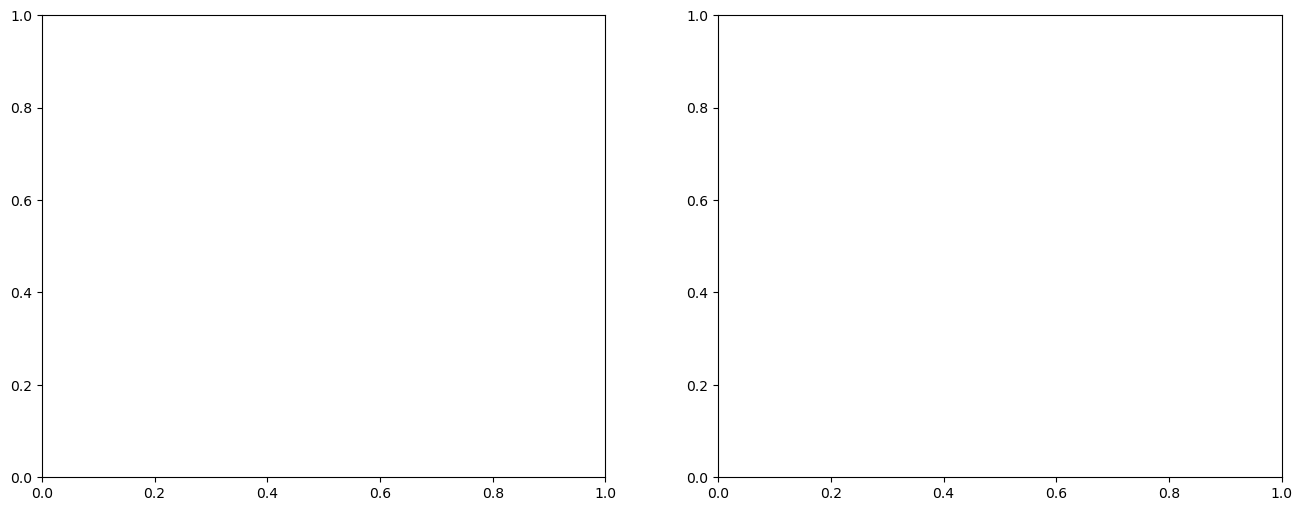

In [21]:
# Creating side-by-side plots for a(t)-values and b(t)-values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plotting a(t)-values
ax1.plot(mid_times, a_values_least_squares, marker='o', linestyle='-', color='blue', label='a(t)-value')
ax1.scatter(times_55, [max(a_values_least_squares)]*len(times_55), marker='^', color='red', s=50, label='M > 5.5')
ax1.scatter(times_6, [max(a_values_least_squares)]*len(times_6), marker='^', color='orange', s=100, label='M > 6')
ax1.scatter(times_7, [max(a_values_least_squares)]*len(times_7), marker='^', color='purple', s=150, label='M > 7')
ax1.set_xlabel('Time')
ax1.set_ylabel('a(t)-value')
ax1.set_title('Temporal Evolution of a(t)-value')
ax1.grid(True)
ax1.legend()

# Plotting b(t)-values
ax2.plot(mid_times, b_values_least_squares, marker='x', linestyle='-', color='green', label='b(t)-value')
ax2.scatter(times_55, [max(b_values_least_squares)]*len(times_55), marker='^', color='red', s=50, label='M > 5.5')
ax2.scatter(times_6, [max(b_values_least_squares)]*len(times_6), marker='^', color='orange', s=100, label='M > 6')
ax2.scatter(times_7, [max(b_values_least_squares)]*len(times_7), marker='^', color='purple', s=150, label='M > 7')
ax2.set_xlabel('Time')
ax2.set_ylabel('b(t)-value')
ax2.set_title('Temporal Evolution of b(t)-value')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()
